In [1]:
import argparse
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import List
import open3d as o3d

from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform_2_xytheta
from robot_utils.geometry import circle_intersection

from segment_track.segment import Segment
from segment_track.tracker import Tracker

from object_map_registration.register.object_registration import ObjectRegistration
from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.object.object import Object
from object_map_registration.object.pointcloud_object import PointCloudObject
from object_map_registration.register.dist_feature_sim_reg import DistOnlyReg, DistVolReg, DistFeaturePCAReg
from object_map_registration.register.dist_reg_with_pruning import DistRegWithPruning, GravityConstraintError
from object_map_registration.register.object_registration import InsufficientAssociationsException
from object_map_registration.utils import object_list_bounds
# from open3d.web_visualizer import draw
import open3d.visualization as vis


%matplotlib widget

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loaded 21 and 34 submaps.


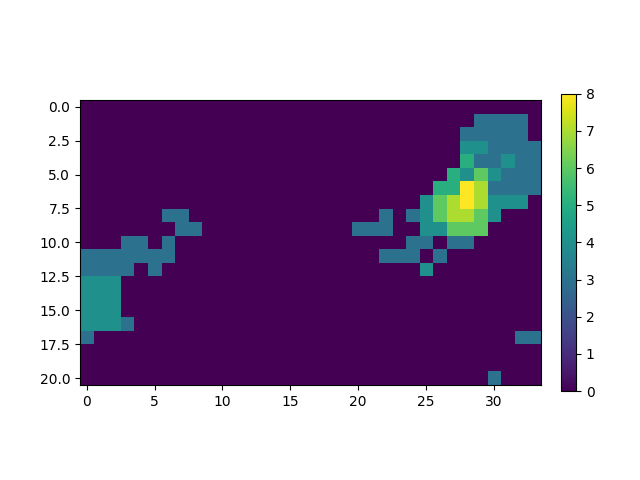

In [3]:
# output_viz_file = '/home/yulun/code/segment_track/outputs/distfeatpca_output_viz.pkl'
output_viz_file = '/home/lucas/Documents/GitLab/dmot/sparse_mapping/segment_track/demo/output/01/volgrav_viz.pkl'
pkl_file = open(output_viz_file, 'rb')
submaps_0, submaps_1, associated_objs_mat, robots_nearby_mat, T_ij_mat, T_ij_hat_mat = pickle.load(pkl_file)
pkl_file.close()
print(f'Loaded {len(submaps_0)} and {len(submaps_1)} submaps.')
clipper_num_associations  =  np.zeros((len(submaps_0), len(submaps_1)))*np.nan

# Find submaps where most associations occur.
max_i = 0
max_j = 0
max_num = 0
for i in range(len(submaps_0)):
  for j in range(len(submaps_1)):
    clipper_num_associations[i, j] =  len(associated_objs_mat[i][j])
    # if clipper_num_associations[i, j] > 0.0:
    #   print(i, j, clipper_num_associations[i, j])
    if len(associated_objs_mat[i][j]) > max_num:
      max_num = len(associated_objs_mat[i][j])
      max_i = i
      max_j = j

plt.imshow(
  clipper_num_associations, 
  vmin=0, 
)
plt.colorbar(fraction=0.03, pad=0.04)
plt.show()

In [4]:
idx_0 = max_i
idx_1 = max_j

# Opposite dir
association = associated_objs_mat[idx_0][idx_1]
submap_0 = [PointCloudObject.from_pickle(data) for data in submaps_0[idx_0]]
submap_1 = [PointCloudObject.from_pickle(data) for data in submaps_1[idx_1]]
print(f'Submap pair ({idx_0}, {idx_1}) contains {len(submap_0)} and {len(submap_1)} objects.')
print(f'Clipper finds {len(association)} associations.')

Submap pair (6, 28) contains 121 and 56 objects.
Clipper finds 8 associations.


In [5]:
# Prepare submaps for visualization
ocd_list_0 = []
ocd_list_1 = []

pcd_ransac_0 = []
pcd_ransac_1 = []

edges = []
red_color = np.asarray([1,0,0]).reshape((1,3))
blue_color = np.asarray([0,0,1]).reshape((1,3))
for seg in submap_0:
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(seg.get_points())
  num_pts = seg.get_points().shape[0]
  rand_color = np.random.uniform(0, 1) * red_color
  rand_color = np.repeat(rand_color, num_pts, axis=0)
  pcd.colors = o3d.utility.Vector3dVector(rand_color)
  
  ocd_list_0.append(pcd)
  pcd_ransac_0.append(pcd.get_center())

for seg in submap_1:
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(seg.get_points())
  num_pts = seg.get_points().shape[0]
  rand_color = np.random.uniform(0, 1) * blue_color
  rand_color = np.repeat(rand_color, num_pts, axis=0)
  pcd.colors = o3d.utility.Vector3dVector(rand_color)
  
  pcd_ransac_1.append(pcd.get_center())
  
  pcd.translate(np.asarray([0,-20,0]))

  ocd_list_1.append(pcd)

In [6]:
# corres = o3d.utility.Vector2iVector([[1, 1], [2, 2], [3, 3]])
corres = []
for i in range(len(pcd_ransac_0)):
    for j in range(len(pcd_ransac_1)):
        corres.append([i, j])

corres = o3d.utility.Vector2iVector(corres)

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(np.asarray(pcd_ransac_0))

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(np.asarray(pcd_ransac_1))

result = o3d.pipelines.registration.registration_ransac_based_on_correspondence(
      source = pcd1,
      target = pcd2,
      corres = corres,
      max_correspondence_distance=0.5,
      ransac_n = 3,
      checkers=[o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9)],
    #   criteria = o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 80000)
      )


In [7]:
ransac_correspondenc = np.asarray(result.correspondence_set)
ransac_correspondenc.shape

(8, 2)

In [8]:
edges = []
for obj_idx_0, obj_idx_1 in ransac_correspondenc:
  print(f'Add edge between {obj_idx_0} and {obj_idx_1}.')
  points = [ocd_list_0[obj_idx_0].get_center(), ocd_list_1[obj_idx_1].get_center()]
  line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector([[0,1]]),
  )
  line_set.colors = o3d.utility.Vector3dVector([[0,1,0]])
  edges.append(line_set)

Add edge between 8 and 7.
Add edge between 33 and 8.
Add edge between 65 and 8.
Add edge between 66 and 7.
Add edge between 71 and 16.
Add edge between 73 and 29.
Add edge between 77 and 29.
Add edge between 79 and 29.


In [9]:
vis.draw_geometries(ocd_list_0 + ocd_list_1 + edges)

### Create an ObjectRegistration class ###

In [10]:
class RANSAC(ObjectRegistration):
    def __init__(self, sigma=0, epsilon=0, mindist=0, dim=3): # We are not using these
        super().__init__(sigma, epsilon, mindist, dim)
    
    def register(self, map1: List[PointCloudObject], map2: List[PointCloudObject]):
        # For RANSAC, we take the center of each object's pointcloud.
        pcd_ransac_1 = []
        pcd_ransac_2 = []

        for seg in map1:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(seg.get_points())
            pcd_ransac_1.append(pcd.get_center())

        for seg in map2:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(seg.get_points())            
            pcd_ransac_2.append(pcd.get_center())
        
        corres = []
        for i in range(len(pcd_ransac_1)):
            for j in range(len(pcd_ransac_2)):
                corres.append([i, j])

        corres = o3d.utility.Vector2iVector(corres)

        pcd1 = o3d.geometry.PointCloud()
        pcd1.points = o3d.utility.Vector3dVector(np.asarray(pcd_ransac_1))

        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector(np.asarray(pcd_ransac_2))

        result = o3d.pipelines.registration.registration_ransac_based_on_correspondence(
            source = pcd1,
            target = pcd2,
            corres = corres,
            max_correspondence_distance=0.5,
            ransac_n = 3,
            checkers=[o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9)],
            )
        
        return np.asarray(result.correspondence_set)

        

In [11]:
ransac_obj_reg = RANSAC()
correspondece = ransac_obj_reg.register(submap_0, submap_1)

In [12]:
edges = []
for obj_idx_0, obj_idx_1 in ransac_correspondenc:
  print(f'Add edge between {obj_idx_0} and {obj_idx_1}.')
  points = [ocd_list_0[obj_idx_0].get_center(), ocd_list_1[obj_idx_1].get_center()]
  line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector([[0,1]]),
  )
  line_set.colors = o3d.utility.Vector3dVector([[0,1,0]])
  edges.append(line_set)

Add edge between 8 and 7.
Add edge between 33 and 8.
Add edge between 65 and 8.
Add edge between 66 and 7.
Add edge between 71 and 16.
Add edge between 73 and 29.
Add edge between 77 and 29.
Add edge between 79 and 29.


In [13]:
vis.draw_geometries(ocd_list_0 + ocd_list_1 + edges)